# Theme 2 - Climate Variability, Ocean Circulation, and Ecosystem
## Climate Variability and Ecosystems
OOI Data Labs Education Nuggets

**Objective**: Demonstrate how to download CTD data from multiple instruments on one OOI Global Flanking Mooring using the Machine-to-Machine (M2M) interface, remove outliers, calculate hourly averages, and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Global Irminger Sea** - CTD data from Flanking Mooring B
    * Instruments:
        * GI03FLMB-RIM01-02-CTDMOG060 (30m)
        * GI03FLMB-RIM01-02-CTDMOG065 (180m)
        * GI03FLMB-RIM01-02-CTDMOH071 (1,500m)
    * Time range: 2014-09-16 to 2017-08-10 (Deployments 1-3)
    * Delivery method: recovered_inst
    * Data stream: ctdmo_ghqr_instrument_recovered
    * Parameters: ctdmo_seawater_pressure, ctdmo_seawater_temperature, practical_salinity, density

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the three instruments of interest. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# GI03FLMB60_url = request_data('GI03FLMB-RIM01-02-CTDMOG060', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                             '2014-09-16T00:00:00.000Z', '2017-08-10T00:00:00.000Z')
# 
# GI03FLMB65_url = request_data('GI03FLMB-RIM01-02-CTDMOG065', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                             '2014-09-16T00:00:00.000Z', '2017-08-10T00:00:00.000Z')
# 
# GI03FLMB71_url = request_data('GI03FLMB-RIM01-02-CTDMOH071', 'recovered_inst', 'ctdmo_ghqr_instrument_recovered',
#                             '2014-09-16T00:00:00.000Z', '2017-08-10T00:00:00.000Z')
# print('GI03FLMB-RIM01-02-CTDMOG060 url = %s' %GI03FLMB60_url)
# print('GI03FLMB-RIM01-02-CTDMOG065 url = %s' %GI03FLMB65_url)
# print('GI03FLMB-RIM01-02-CTDMOH071 url =  %s' %GI03FLMB71_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
CTD30m_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191018T145750777Z-GI03FLMB-RIM01-02-CTDMOG060-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
CTD180m_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191018T145751205Z-GI03FLMB-RIM01-02-CTDMOG065-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'
CTD1500m_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191018T145751575Z-GI03FLMB-RIM01-02-CTDMOH071-recovered_inst-ctdmo_ghqr_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables of interest and get the data for the three datasets. An option in the get_data function is to specify deployments (dps), and we only want data from deployments 1, 2, and 3 for this exercise. The global mooring deployments overlap, sometimes by as much as two weeks. So even though we only requested data through the end date of deployment 3 (Aug 11, 2017), we will also receive a NetCDF file containing data from the beginning of deployment 4 because that deployment started on Aug 7, 2017. We can filter that deployment 4 file out of the dataset.

In [7]:
# Specify the variable(s) of interest and get the data for the three datasets
variables = ['ctdmo_seawater_pressure', 'ctdmo_seawater_temperature', 'practical_salinity', 'density']
dps = [1, 2, 3]  # deployments to keep

CTD30m_data, CTD30m_units = get_data(CTD30m_url, variables, dps)
CTD180m_data, CTD180m_units = get_data(CTD180m_url, variables, dps)
CTD1500m_data, CTD1500m_units = get_data(CTD1500m_url, variables, dps)
print(CTD1500m_units)

Appending data from files
Appending data from files
Appending data from files
{'ctdmo_seawater_pressure': ['dbar'], 'ctdmo_seawater_temperature': ['ºC'], 'practical_salinity': ['1'], 'density': ['kg m-3']}


## Quick Data Plots
Make quick plots to make sure you downloaded the correct data.

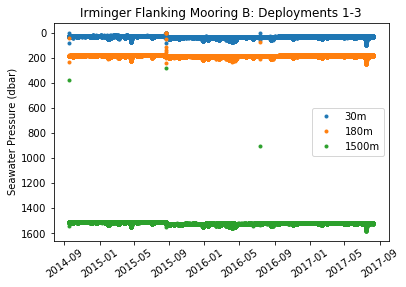

In [8]:
# Plot the pressure data to make sure you have the CTDs you were expecting
fig, ax = plt.subplots()
plt.plot(CTD30m_data['time'], CTD30m_data['ctdmo_seawater_pressure'], '.', label='30m')
plt.plot(CTD180m_data['time'], CTD180m_data['ctdmo_seawater_pressure'], '.', label='180m')
plt.plot(CTD1500m_data['time'], CTD1500m_data['ctdmo_seawater_pressure'], '.', label='1500m')
ax.legend()
ax.invert_yaxis()
ax.set_xlabel('')
ax.set_ylabel('Seawater Pressure ({})'.format(CTD30m_units['ctdmo_seawater_pressure'][0]))
ax.set_title('Irminger Flanking Mooring B: Deployments 1-3')
plt.xticks(rotation=35);

There are a few outliers scattered throughout these datasets, usually concentrated near the deployment start/end times. Because these moorings are in very deep waters, it can take several hours for the mooring to completely settle and those data points are most likely captured as the instruments are sinking to their final deployment depth. Similarly, at recovery some data points can be captured as the instruments rise in the water column.

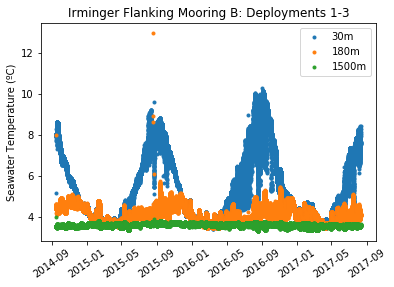

In [9]:
# Make a quick plot of temperature
fig, ax = plt.subplots()
plt.plot(CTD30m_data['time'], CTD30m_data['ctdmo_seawater_temperature'], '.', label='30m')
plt.plot(CTD180m_data['time'], CTD180m_data['ctdmo_seawater_temperature'], '.', label='180m')
plt.plot(CTD1500m_data['time'], CTD1500m_data['ctdmo_seawater_temperature'], '.', label='1500m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Seawater Temperature ({})'.format(CTD30m_units['ctdmo_seawater_temperature'][0]))
ax.set_title('Irminger Flanking Mooring B: Deployments 1-3')
plt.xticks(rotation=35);

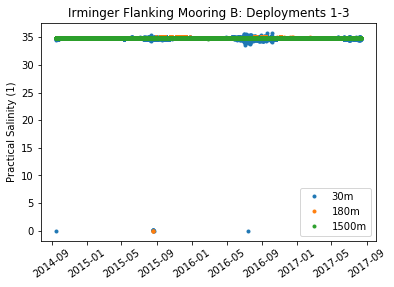

In [10]:
# ...and salinity - the outliers here at the beginning of each deployment are very obvious
fig, ax = plt.subplots()
plt.plot(CTD30m_data['time'], CTD30m_data['practical_salinity'], '.', label='30m')
plt.plot(CTD180m_data['time'], CTD180m_data['practical_salinity'], '.', label='180m')
plt.plot(CTD1500m_data['time'], CTD1500m_data['practical_salinity'], '.', label='1500m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Practical Salinity ({})'.format(CTD30m_units['practical_salinity'][0]))
ax.set_title('Irminger Flanking Mooring B: Deployments 1-3')
plt.xticks(rotation=35);

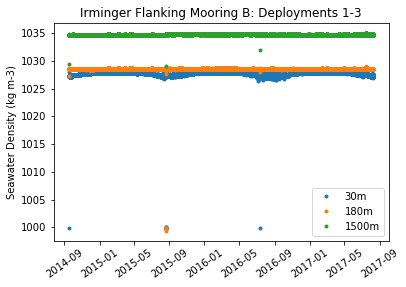

In [11]:
# ...and density - again, the outliers are very obvious
fig, ax = plt.subplots()
plt.plot(CTD30m_data['time'], CTD30m_data['density'], '.', label='30m')
plt.plot(CTD180m_data['time'], CTD180m_data['density'], '.', label='180m')
plt.plot(CTD1500m_data['time'], CTD1500m_data['density'], '.', label='1500m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Seawater Density ({})'.format(CTD30m_units['density'][0]))
ax.set_title('Irminger Flanking Mooring B: Deployments 1-3')
plt.xticks(rotation=35);

We'll want to remove those outliers before calculating hourly averages (to make the csv files more manageable). Here's a function to remove the outliers from the dataframe (it removes the entire row of data if one variable is an outlier).

In [12]:
def remove_outliers(df, variables, m):
    cnames = []
    for v in variables:
        mn = np.nanmean(df[v])
        std = np.nanstd(df[v])
        cname = v + '_ind'
        cnames.append(cname)
        df[cname] = abs(df[v] - mn) < m * std
    for cn in cnames:
        df_filtered = df.loc[df[cn] == True]
    df_filt = df_filtered.drop(columns=cnames)
    return df_filt

Specify the # of standard deviations from the mean you want to remove. In this example we'll remove any data points that are more than 5 standard deviations from the mean.

In [13]:
std_from_mean = 5
CTD30m_data_clean = remove_outliers(CTD30m_data, variables, std_from_mean)
CTD180m_data_clean = remove_outliers(CTD180m_data, variables, std_from_mean)
CTD1500m_data_clean = remove_outliers(CTD1500m_data, variables, std_from_mean)

Plot the salinity and density data again to make sure you removed all of the outliers

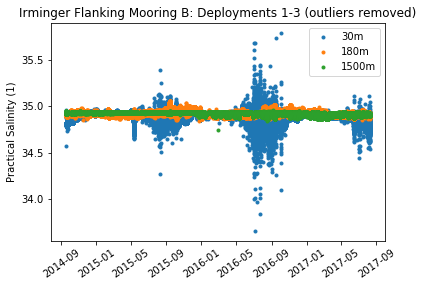

In [14]:
fig, ax = plt.subplots()
plt.plot(CTD30m_data_clean['time'], CTD30m_data_clean['practical_salinity'], '.', label='30m')
plt.plot(CTD180m_data_clean['time'], CTD180m_data_clean['practical_salinity'], '.', label='180m')
plt.plot(CTD1500m_data_clean['time'], CTD1500m_data_clean['practical_salinity'], '.', label='1500m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Practical Salinity ({})'.format(CTD30m_units['practical_salinity'][0]))
ax.set_title('Irminger Flanking Mooring B: Deployments 1-3 (outliers removed)')
plt.xticks(rotation=35);

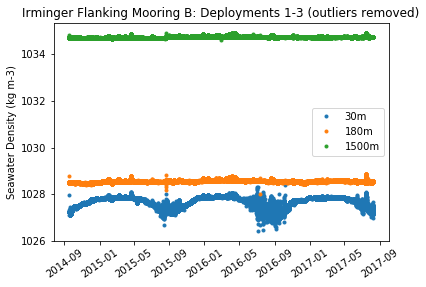

In [15]:
fig, ax = plt.subplots()
plt.plot(CTD30m_data_clean['time'], CTD30m_data_clean['density'], '.', label='30m')
plt.plot(CTD180m_data_clean['time'], CTD180m_data_clean['density'], '.', label='180m')
plt.plot(CTD1500m_data_clean['time'], CTD1500m_data_clean['density'], '.', label='1500m')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Seawater Density ({})'.format(CTD30m_units['density'][0]))
ax.set_title('Irminger Flanking Mooring B: Deployments 1-3 (outliers removed)')
plt.xticks(rotation=35);

Looks much better! Now we can calculate hourly averages (to make the dataset more manageable), merge the datasets, and export as a .csv

## 3. Merge and export

In [16]:
# rename and add units to the columns
CTD30m_data_clean = CTD30m_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD30m Pressure ({})'.format(CTD30m_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD30m Temp (deg_C)',
                                                     'practical_salinity': 'CTD30m Salinity ({})'.format(CTD30m_units['practical_salinity'][0]),
                                                     'density': 'CTD30m Density ({})'.format(CTD30m_units['density'][0])})

CTD180m_data_clean = CTD180m_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD180m Pressure ({})'.format(CTD180m_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD180m Temp (deg_C)',
                                                     'practical_salinity': 'CTD180m Salinity ({})'.format(CTD180m_units['practical_salinity'][0]),
                                                     'density': 'CTD180m Density ({})'.format(CTD180m_units['density'][0])})

CTD1500m_data_clean = CTD1500m_data_clean.rename(columns={'ctdmo_seawater_pressure': 'CTD1500m Pressure ({})'.format(CTD1500m_units['ctdmo_seawater_pressure'][0]),
                                                     'ctdmo_seawater_temperature': 'CTD1500m Temp (deg_C)',
                                                     'practical_salinity': 'CTD1500m Salinity ({})'.format(CTD1500m_units['practical_salinity'][0]),
                                                     'density': 'CTD1500m Density ({})'.format(CTD1500m_units['density'][0])})

# calculate hourly averages for each dataframe
CTD30m_hourly = CTD30m_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()
CTD180m_hourly = CTD180m_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()
CTD1500m_hourly = CTD1500m_data_clean.resample('H', on='time').mean().dropna(how='all').reset_index()

# merge the dataframes and export to csv
merge1 = pd.merge(CTD30m_hourly, CTD180m_hourly, on='time', how='outer')
merged = pd.merge(merge1, CTD1500m_hourly, on='time', how='outer')
merged = merged.sort_values('time').reset_index(drop=True)  # make sure the dataframe is sorted by time

In [17]:
# print the column names of the new merged dataframe
print(merged.columns)

Index(['time', 'CTD30m Pressure (dbar)', 'CTD30m Temp (deg_C)',
       'CTD30m Salinity (1)', 'CTD30m Density (kg m-3)',
       'CTD180m Pressure (dbar)', 'CTD180m Temp (deg_C)',
       'CTD180m Salinity (1)', 'CTD180m Density (kg m-3)',
       'CTD1500m Pressure (dbar)', 'CTD1500m Temp (deg_C)',
       'CTD1500m Salinity (1)', 'CTD1500m Density (kg m-3)'],
      dtype='object')


Now that we have our hourly-averaged, merged dataframe, let's plot the variables to make sure it looks reasonable.

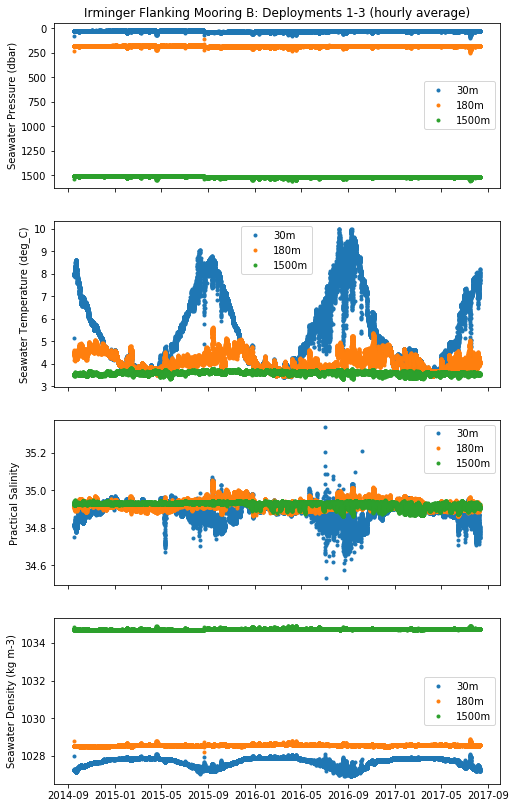

In [18]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize = (8,14))
ax1.plot(merged['time'], merged['CTD30m Pressure (dbar)'], '.', label='30m')
ax1.plot(merged['time'], merged['CTD180m Pressure (dbar)'], '.', label='180m')
ax1.plot(merged['time'], merged['CTD1500m Pressure (dbar)'], '.', label='1500m')
ax1.invert_yaxis()
ax1.legend()
ax1.set_xlabel('')
ax1.set_ylabel('Seawater Pressure (dbar)')
ax1.set_title('Irminger Flanking Mooring B: Deployments 1-3 (hourly average)')

ax2.plot(merged['time'], merged['CTD30m Temp (deg_C)'], '.', label='30m')
ax2.plot(merged['time'], merged['CTD180m Temp (deg_C)'], '.', label='180m')
ax2.plot(merged['time'], merged['CTD1500m Temp (deg_C)'], '.', label='1500m')
ax2.legend()
ax2.set_xlabel('')
ax2.set_ylabel('Seawater Temperature (deg_C)')

ax3.plot(merged['time'], merged['CTD30m Salinity (1)'], '.', label='30m')
ax3.plot(merged['time'], merged['CTD180m Salinity (1)'], '.', label='180m')
ax3.plot(merged['time'], merged['CTD1500m Salinity (1)'], '.', label='1500m')
ax3.legend()
ax3.set_xlabel('')
ax3.set_ylabel('Practical Salinity')

ax4.plot(merged['time'], merged['CTD30m Density (kg m-3)'], '.', label='30m')
ax4.plot(merged['time'], merged['CTD180m Density (kg m-3)'], '.', label='180m')
ax4.plot(merged['time'], merged['CTD1500m Density (kg m-3)'], '.', label='1500m')
ax4.legend()
ax4.set_xlabel('')
ax4.set_ylabel('Seawater Density (kg m-3)');

In [19]:
# Looks good! Export to csv
merged.to_csv(os.path.join(save_dir, 'Theme2a_Irminger_CTDs.csv'), index=False)